### <font color="black" size='3'><b>Grupo em ordem alfabética  </b></font>
<html>
<table border="1px">
<tr>
<td bgcolor="Aquamarine">Nome do Aluno</td>
<td bgcolor="Aquamarine">RA</td>
</tr>
<tr>
<td bgcolor="white">Alcir Canella Filho</td>
<td bgcolor="white">10396389</td>
</tr>
<tr>
<td bgcolor="white">Felipe Clé Monteiro</td>
<td bgcolor="white">10395521</td>
</tr>
    <tr>
<td bgcolor="white">Matheus Marques</td>
<td bgcolor="white">10395894</td>
</tr>
    </table>
</html>

# **Bibliotecas e Instalações**

In [25]:
%%capture 

!pip install shap
!pip install optuna
!pip install xgboost
!pip install lightgbm

In [26]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '10'  # Qtde de núcleos da CPU

In [27]:
seed = 10 # semente para o random_state
# Básicas
import pandas as pd
import numpy as np
import plotly.express as px

# Modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

#Otimização Hiperparametros
import optuna
from optuna.samplers import RandomSampler
from optuna.visualization import plot_optimization_history

In [28]:
import sklearn
import xgboost
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', sklearn.__version__)
print('optuna:', optuna.__version__)
print('xgboost:', xgboost.__version__)

pandas: 2.2.2
numpy: 1.26.4
sklearn: 1.5.1
optuna: 4.2.1
xgboost: 2.1.4


In [29]:
#Arquivo separado com algumas funções mais complexas, para deixar este notebook mais organizado
from functions import *

# **Introdução**

**Ideia Geral**

Utilizando os dados de câncer da FOSP, selecionados para Câncer de Prostata, serão utilizados três modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida por cinco anos(Para o trabalho completo, serão utilizados todas as labels de tempo criadas, para este projeto utilizaremos apenas a de 5 anos).

> O label é 0 se o paciente não sobreviveu após cinco anos do diagnóstico e 1 se sobreviveu.

In [31]:
df= pd.read_csv('data_preProcess2.csv', sep = ',', encoding = 'UTF-8',low_memory=False)

In [32]:
df.shape

(56874, 33)

In [33]:
# Valores faltantes
df.isna().sum().sort_values(ascending=False).head(6)

ESCOLARI        0
CONSDIAG        0
vivo_ano3       0
vivo_ano1       0
obito_cancer    0
obito_geral     0
dtype: int64

In [34]:
# Correlação com a saída
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.794691
ULTICONS        0.786757
ULTITRAT        0.783693
vivo_ano3       0.680546
ANODIAG         0.426704
vivo_ano1       0.335474
CATEATEND       0.194365
obito_cancer    0.160162
RECNENHUM       0.134600
IBGEATEN        0.125488
DRS             0.099729
ESCOLARI        0.091185
RRAS            0.085260
obito_geral     0.083372
QUIMIO          0.081209
IDADE           0.078164
IBGE            0.075074
DIAGTRAT        0.073718
CIRURGIA        0.072274
Name: vivo_ano5, dtype: float64

In [35]:
#Dados com valores categoricos.
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
print(non_numeric_cols)


Index(['EC', 'TRATHOSP'], dtype='object')


In [36]:
# Quantidade de pacientes em cada classe da saída
df.vivo_ano5.value_counts()

vivo_ano5
1    29363
0    27511
Name: count, dtype: int64

## **DataFrame vivo_ano5**

 - Antes de realizar o pré-processamento dos dados é necessário filtrar os dados, de modo a retirar pacientes que não foram acompanhados por pelo **menos cinco** anos e que a última informação consta como vivos.
 - Nesta função realizamos alguns tipos de pre-processamentos, como principais podemos citar:(para mais detalhes consultar "functions.py")
     - Filtragem por intervalo de anos, no caso a coluna vivo_ano5 que escolhemos.
     - Divisão Treinamento/teste
     - Codificação e Normalização dos dados de treino e teste
     - Balanceamento: Usa SMOTE para balancear os dados de treinamento.
     - Seleção de features,etc...

In [38]:
# Seleção realizada abaixo:
df_ano5 = df[~((df.obito_geral == 0) & (df.vivo_ano5 == 0))].reset_index(drop=True)
df_ano5.shape

(39332, 33)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56874 entries, 0 to 56873
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ESCOLARI      56874 non-null  int64 
 1   IDADE         56874 non-null  int64 
 2   IBGE          56874 non-null  int64 
 3   CATEATEND     56874 non-null  int64 
 4   DIAGPREV      56874 non-null  int64 
 5   EC            56874 non-null  object
 6   TRATHOSP      56874 non-null  object
 7   NENHUM        56874 non-null  int64 
 8   CIRURGIA      56874 non-null  int64 
 9   RADIO         56874 non-null  int64 
 10  QUIMIO        56874 non-null  int64 
 11  HORMONIO      56874 non-null  int64 
 12  TMO           56874 non-null  int64 
 13  IMUNO         56874 non-null  int64 
 14  OUTROS        56874 non-null  int64 
 15  NENHUMANT     56874 non-null  int64 
 16  ULTINFO       56874 non-null  int64 
 17  CONSDIAG      56874 non-null  int64 
 18  TRATCONS      56874 non-null  int64 
 19  DIAG

In [40]:
list_drop = ['ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'obito_geral',
             'vivo_ano1', 'vivo_ano3', 'ULTINFO', 'obito_cancer','ESCOLARI']

lb = 'vivo_ano5'

In [49]:
X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_ano5, list_drop, lb, 
                                                                       random_state=seed,
                                                                       balance_data=True,
                                                                       encoder_type='LabelEncoder', 
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True)

X_train = (44044, 23), X_test = (9833, 23)
y_train = (44044,), y_test = (9833,)


In [57]:
y_train.value_counts(normalize=True)

vivo_ano5
1    0.5
0    0.5
Name: proportion, dtype: float64

In [59]:
y_test.value_counts(normalize=True)

vivo_ano5
1    0.746568
0    0.253432
Name: proportion, dtype: float64

# Naive Bayes


In [62]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

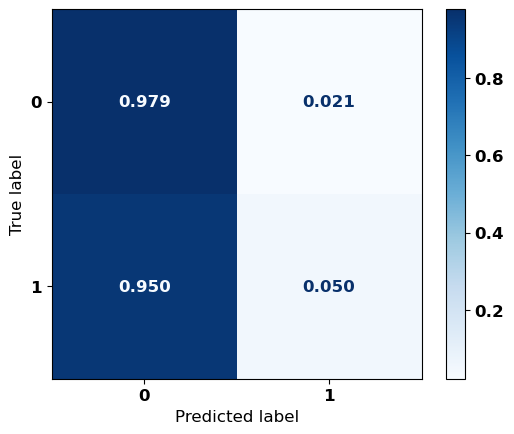


              precision    recall  f1-score   support

           0      0.259     0.979     0.410      2492
           1      0.874     0.050     0.095      7341

    accuracy                          0.286      9833
   macro avg      0.567     0.514     0.252      9833
weighted avg      0.718     0.286     0.175      9833



In [64]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

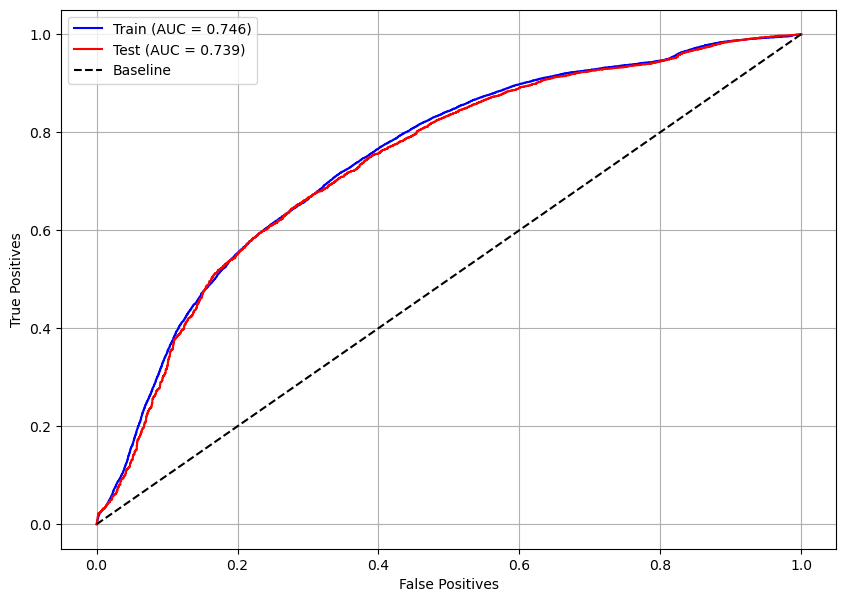

In [66]:
# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

- Pelas curvas ROC, pode-se dizer que não há overfitting, mas o modelo é ruim para a previsão da classe 1, portanto não seguiremos com análises, neste caso, com este modelo.

### **Random Forest**

O modelo Random Forest é mais complexo em relação ao Naive Bayes, assim alguns hiperparâmetros serão definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

-   `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável  `seed`.
    
-   `max_depth`: será definido como 8, pois o padrão do modelo é não ter profundidade máxima para as árvores, o que dificulta e faz o treinamento ser muito longo, além da maior chance de overfitting.
    
-   `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo, util no caso de classes desbalanceadas, aqui elas foram balanceadas previamente então vamos usar None

In [70]:
class_weights = {0: 1.28, 1: 1}  


rf = RandomForestClassifier(random_state=seed, 
                            class_weight=class_weights,
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 1.28, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

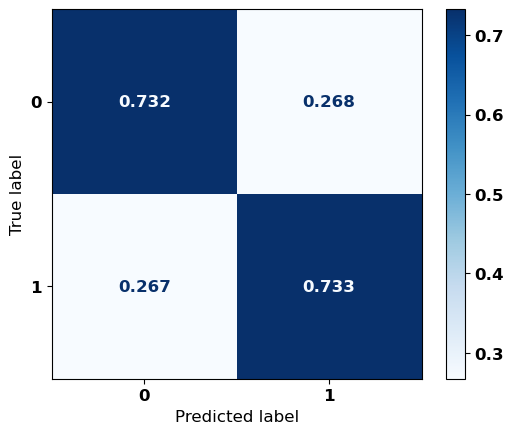


              precision    recall  f1-score   support

           0      0.482     0.732     0.581      2492
           1      0.889     0.733     0.803      7341

    accuracy                          0.732      9833
   macro avg      0.686     0.732     0.692      9833
weighted avg      0.786     0.732     0.747      9833



In [71]:
# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

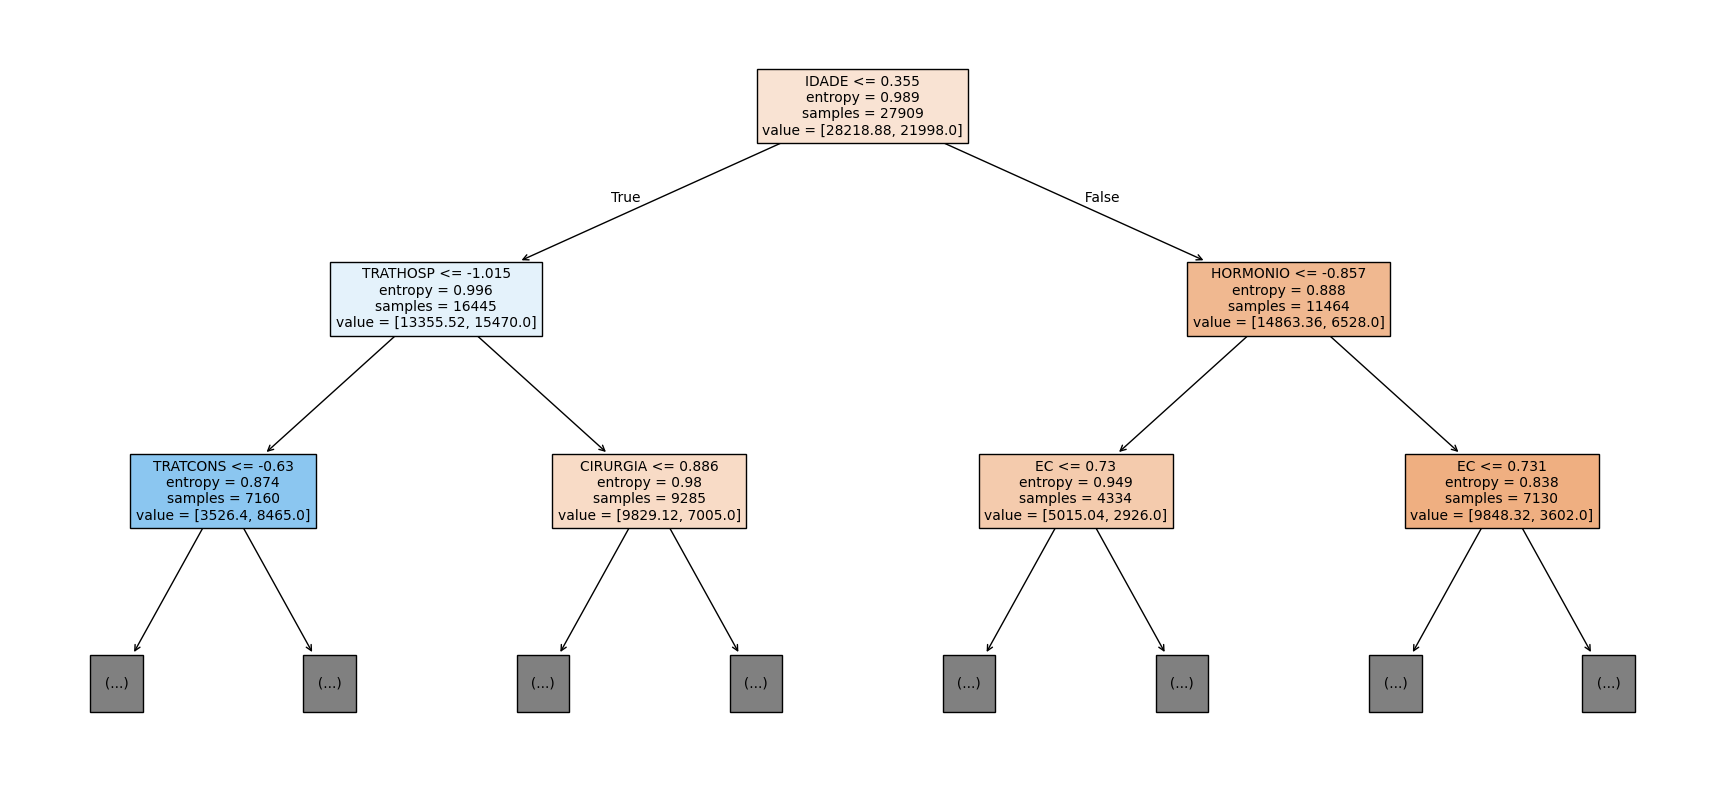

In [72]:
show_tree(rf, feat_cols, 2)

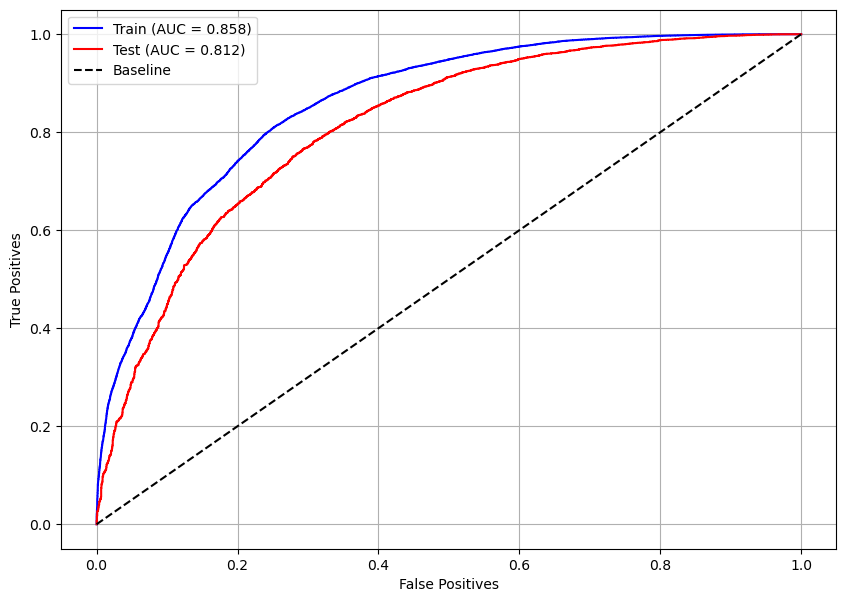

In [73]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

In [79]:
def plot_feat_importances(model, feat_cols, n=10):
    feat_import = pd.Series(model.feature_importances_, index=feat_cols)
    feat_import.nlargest(n).plot(kind='barh', figsize=(10, 8))
    plt.show()

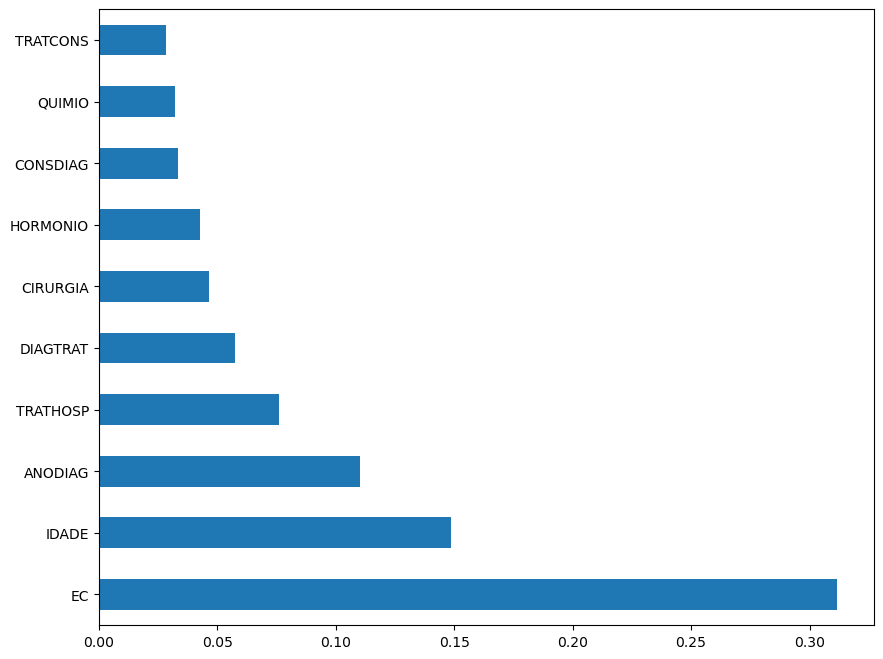

In [81]:
plot_feat_importances(rf, feat_cols)


> As features mais importantes nesta visualização são  `EC`, com uma grande vantagem,  `IDADE`,  `ANODIAG`  e  `CIRURGIA`.

#### Optuna

- Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [85]:
#Folds para validação (Scikit)
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [87]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples, 
                                 criterion=optimizer,
                                 random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()
     

In [89]:
# Criação do estudo e procura pelos hiperparâmetros
import warnings # Suprimir todos os warnings 
warnings.filterwarnings("ignore")
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100)

[I 2025-03-03 11:41:15,052] A new study created in memory with name: no-name-566caa26-03a5-477c-b7c9-f3fc94277b0b
[I 2025-03-03 11:41:35,533] Trial 0 finished with value: 0.7258195516558834 and parameters: {'n_estimators': 205, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_samples': 0.7999999999999999, 'criterion': 'gini'}. Best is trial 0 with value: 0.7258195516558834.
[I 2025-03-03 11:42:11,836] Trial 1 finished with value: 0.7482511153356642 and parameters: {'n_estimators': 202, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_samples': 1.0, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7482511153356642.
[I 2025-03-03 11:43:24,302] Trial 2 finished with value: 0.8043544576114728 and parameters: {'n_estimators': 213, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_samples': 1.0, 'criterion': 'gini'}. Best is trial 2 with value: 0.8043544576114728.
[I 2025-03-03 11:43:40,013] Trial 3 finished with value: 0.7698887

In [99]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=62, state=1, values=[0.842497968462624], datetime_start=datetime.datetime(2025, 3, 3, 12, 20, 1, 690170), datetime_complete=datetime.datetime(2025, 3, 3, 12, 21, 6, 671247), params={'n_estimators': 173, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_samples': 0.7999999999999999, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=62, value=None)

In [101]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 173,
 'max_depth': 18,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_samples': 0.7999999999999999,
 'criterion': 'gini'}

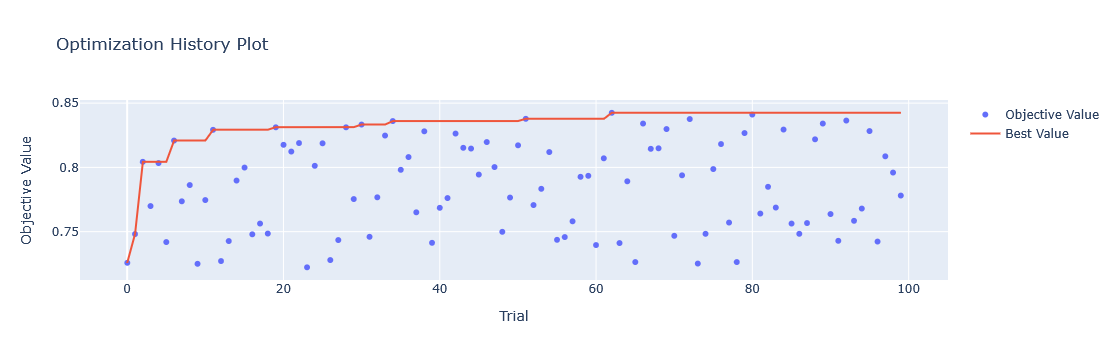

In [103]:
plot_optimization_history(studyRF).show()

In [105]:
from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    # Usar F1-score para otimizar o equilíbrio entre TP e TN
    return f1_score(y_true, y_pred, average='weighted')

# Criar o custom scorer
scorer = make_scorer(custom_scorer, greater_is_better=True)


In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parâmetros para Grid Search
param_grid = {
    'class_weight': [{0: w0, 1: w1} for w0 in [1, 1.25, 1.5, 2] for w1 in [0.5, 1, 1.5]]
}

# Inicializar o RandomForestClassifier
rf = RandomForestClassifier(random_state=seed, max_depth=8, criterion='entropy')

# Configurar o Grid Search
grid_search = GridSearchCV(rf, param_grid, scoring=scorer, cv=skf)

# Executar o Grid Search
grid_search.fit(X_train, y_train)

# Obter e imprimir os melhores parâmetros
best_params = grid_search.best_params_

# Extraindo os melhores pesos das classes
best_class_weights = best_params['class_weight']
print(f"Os melhores pesos das classes são: {best_class_weights}")


Os melhores pesos das classes são: {0: 1, 1: 1}


In [108]:
from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

scorer = make_scorer(custom_scorer, greater_is_better=True)


In [397]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0: 2.57, 1: 1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 2.57, 1: 1}, max_depth=18,
                       max_samples=0.7999999999999999, min_samples_split=8,
                       n_estimators=173, random_state=10)

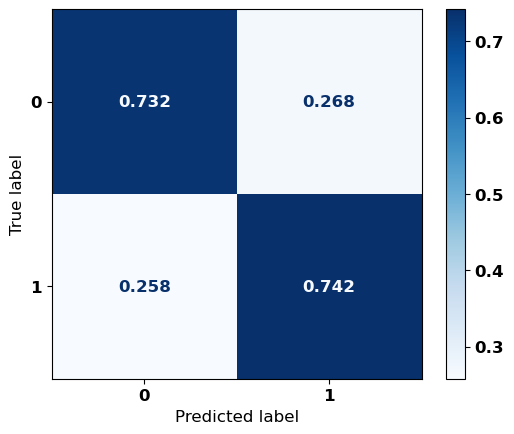


              precision    recall  f1-score   support

           0      0.491     0.732     0.588      2492
           1      0.891     0.742     0.810      7341

    accuracy                          0.740      9833
   macro avg      0.691     0.737     0.699      9833
weighted avg      0.789     0.740     0.753      9833



In [395]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

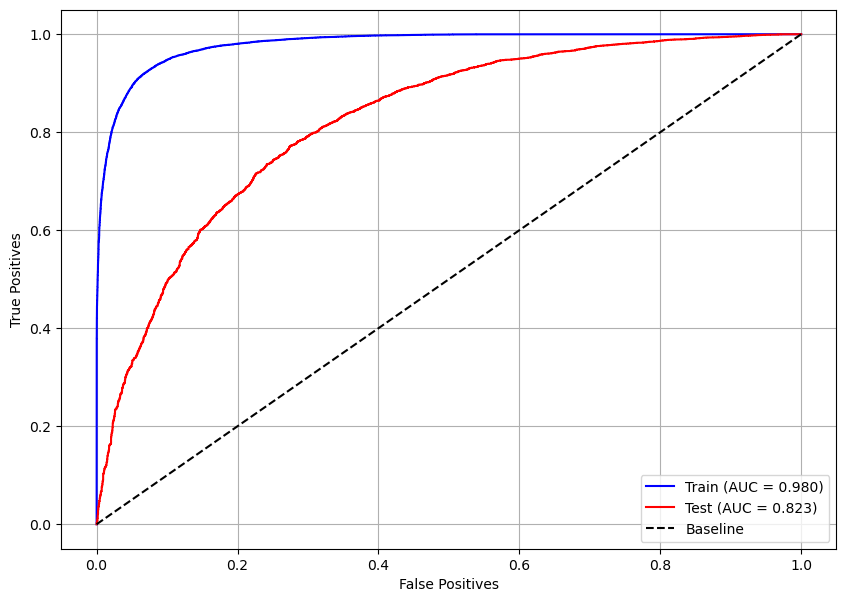

In [48]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

### **XGBoost**

O modelo XGBoost também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

-   `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável  `seed`.
    
-   `max_depth`: será utilizado o padrão, com valor 3.
    
-   `scale_pos_weight`: usado para definir o peso da classe 1 no treinamento do modelo, pois temos classes desbalanceadas.

In [222]:
# Criação e treinamento do modelo XGBoost 
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=0.437,
                    random_state=seed)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=10, ...)

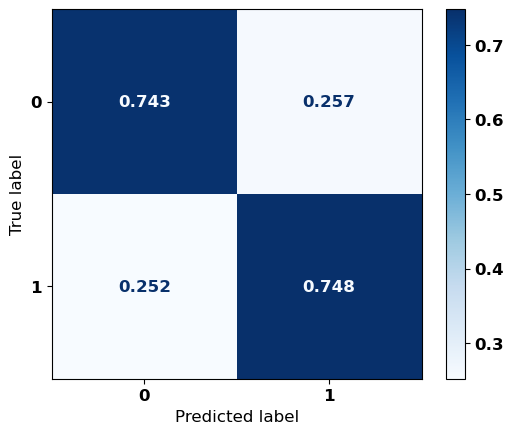


              precision    recall  f1-score   support

           0      0.500     0.743     0.598      2492
           1      0.895     0.748     0.815      7341

    accuracy                          0.746      9833
   macro avg      0.698     0.745     0.706      9833
weighted avg      0.795     0.746     0.760      9833



In [224]:
# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

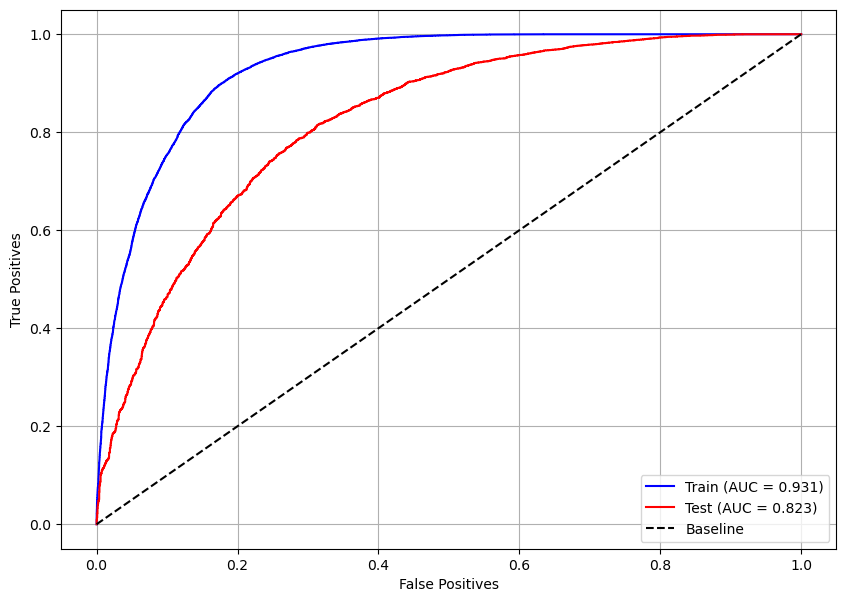

In [52]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

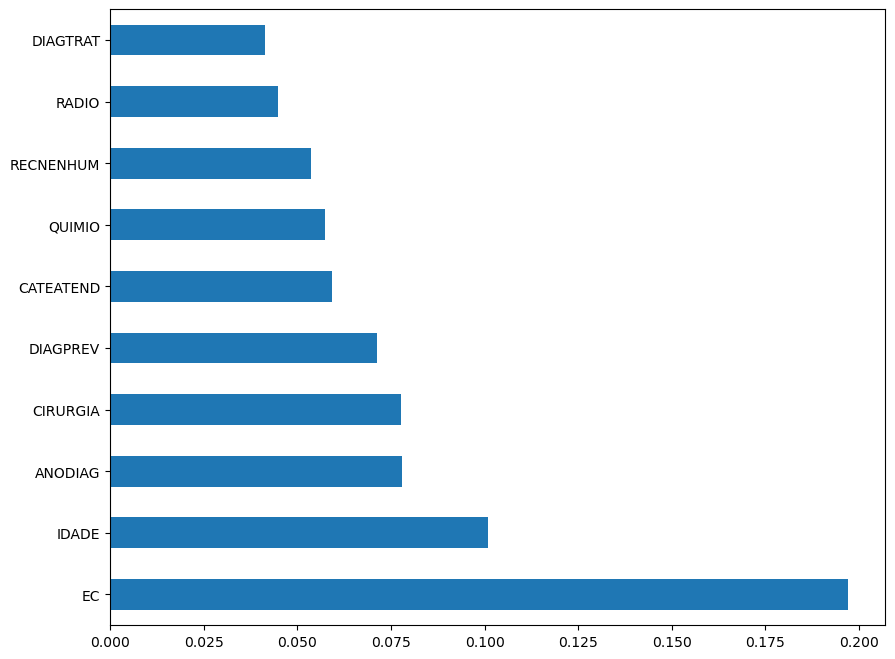

In [53]:
# Importância das features
plot_feat_importances(xgb, feat_cols)

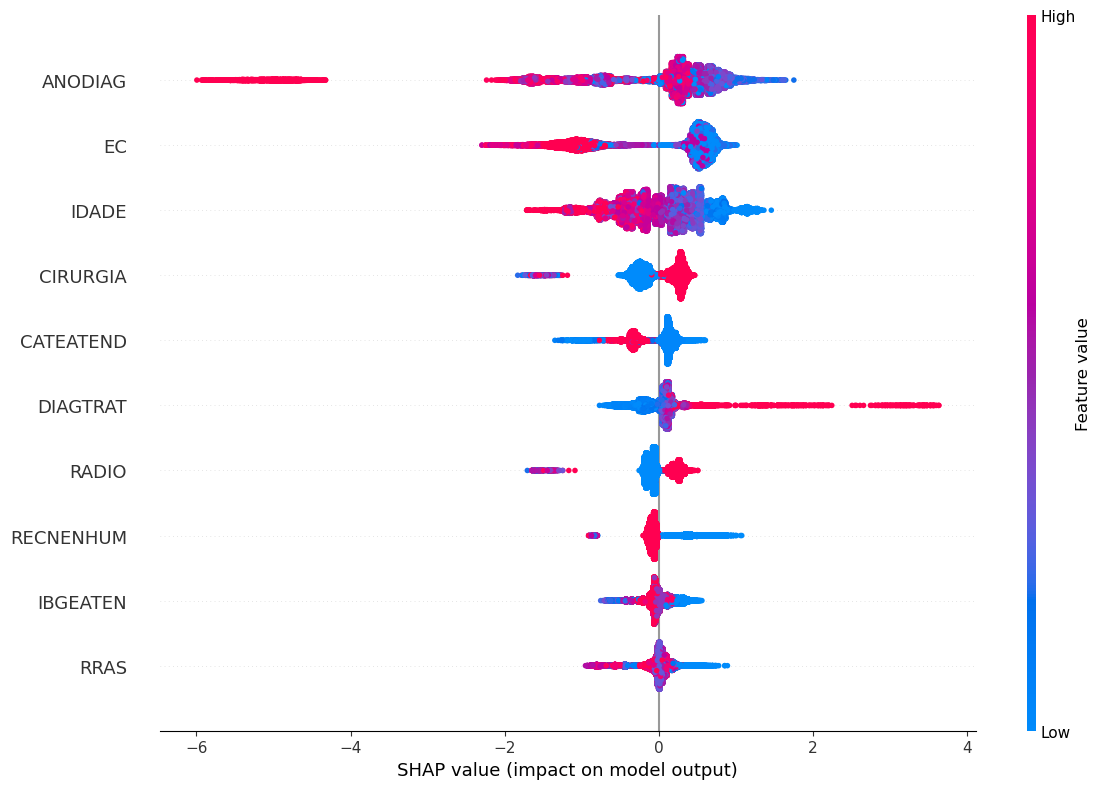

In [226]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

In [215]:
from sklearn.metrics import make_scorer, f1_score

def custom_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

scorer = make_scorer(custom_scorer, greater_is_better=True)


In [423]:
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.18
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6000000000000001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=107,
              n_jobs=None, num_parallel_tree=None, random_state=10, ...)

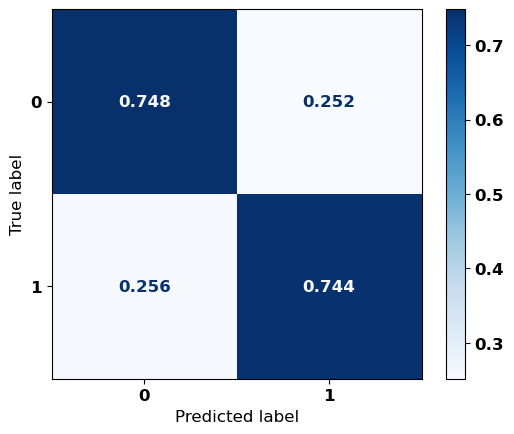


              precision    recall  f1-score   support

           0      0.498     0.748     0.598      2492
           1      0.897     0.744     0.813      7341

    accuracy                          0.745      9833
   macro avg      0.698     0.746     0.706      9833
weighted avg      0.796     0.745     0.759      9833



In [425]:
# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

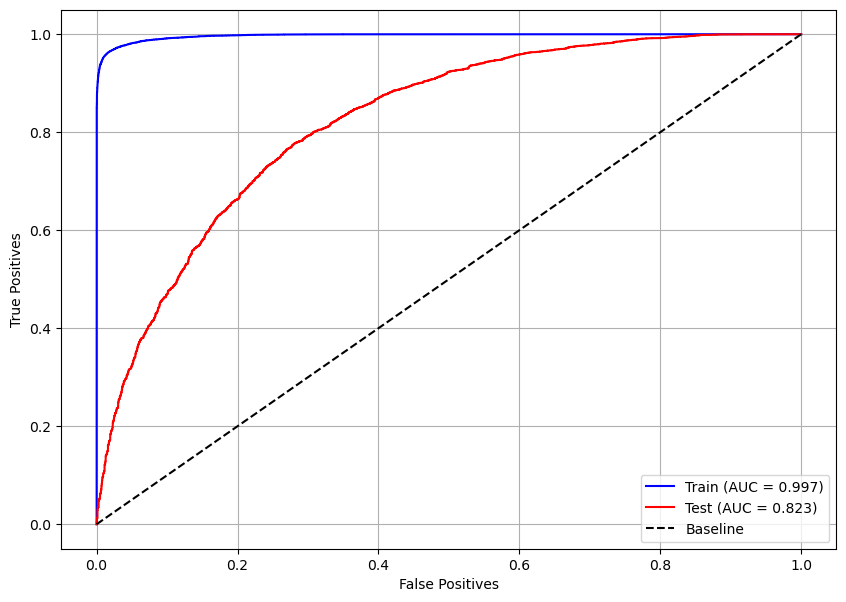

In [379]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)